In [22]:
import xarray as xr
import matplotlib
import xesmf as xe
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import cartopy.crs as crs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
from netCDF4 import Dataset
import matplotlib.patches as mpatches
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim, xy, ll_to_xy,
                 cartopy_ylim, latlon_coords, CoordPair, GeoBounds, interp2dxy)
import proplot as pplt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import datetime as dt
import cftime
from scipy.interpolate import RegularGridInterpolator

In [23]:
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['tick.labelsize']   = 16
#pplt.rc['legend.fontsize']  = '10em'

## read data

In [24]:
depths_roots = np.asarray([0.1, 0.4, 1.0, 2.0, 3.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0])
depths_orig  = np.asarray([0.1, 0.4, 1.0, 2.0])

In [25]:
wrf_path  = '/glade/u/home/cab478/hrldas_resources/resources/wrfinput_d01'
data_path = '/glade/u/home/cab478/'
geogrid   = '/glade/u/home/cab478/WPS/geo_em.d01.nc'

In [26]:
# Open the NetCDF file
ncfile = Dataset(wrf_path)
dummy  = getvar(ncfile, "SHDMAX")
cart_proj  = get_cartopy(dummy)
# Get the latitude and longitude points
lats, lons = latlon_coords(dummy)

In [27]:
lai    = getvar(Dataset(geogrid),'LAI12M')
topo   = getvar(Dataset(geogrid),'HGT_M')
luse   = getvar(Dataset(geogrid),'LU_INDEX')
sltyp  = getvar(Dataset(wrf_path),'ISLTYP')
fdepth = getvar(Dataset(wrf_path),'FDEPTH')

In [38]:
def read():

    run_data = {'fd':{}, 'gw':{}, 'soil':{}, 'roots':{}}
    
    for run in ['fd', 'gw', 'soil', 'roots']:

        for pt in ['jbr', 'fns', 'high', 'mid', 'low']:
            
            name = data_path + run + '_' + pt + '.nc'
            print(name)
            data = xr.open_dataset(name, engine='netcdf4')

            run_data[run][pt] = data

    return run_data

In [39]:
data = read()

/glade/u/home/cab478/fd_jbr.nc
/glade/u/home/cab478/fd_fns.nc
/glade/u/home/cab478/fd_high.nc
/glade/u/home/cab478/fd_mid.nc
/glade/u/home/cab478/fd_low.nc
/glade/u/home/cab478/gw_jbr.nc
/glade/u/home/cab478/gw_fns.nc
/glade/u/home/cab478/gw_high.nc
/glade/u/home/cab478/gw_mid.nc
/glade/u/home/cab478/gw_low.nc
/glade/u/home/cab478/soil_jbr.nc
/glade/u/home/cab478/soil_fns.nc
/glade/u/home/cab478/soil_high.nc
/glade/u/home/cab478/soil_mid.nc
/glade/u/home/cab478/soil_low.nc
/glade/u/home/cab478/roots_jbr.nc
/glade/u/home/cab478/roots_fns.nc
/glade/u/home/cab478/roots_high.nc
/glade/u/home/cab478/roots_mid.nc
/glade/u/home/cab478/roots_low.nc


In [40]:
site_labels = ['Forest point (JBR)', 'Savanna point (FNS)', 'Highland point', 'Lowland point' , 'Midslope point']

## plot daily time series

In [41]:
def etpcpsm():

    i = 0
    
    for pt in ['jbr', 'fns', 'high', 'mid', 'low']:

            fig = pplt.figure(refwidth='45em', refheight='15em', sharey=False, sharex=True, spanx=True)
            array = [  # the "picture" (0 == nothing, 1 == subplot A, 2 == subplot B, etc.)
            [1, 2, 3, 0],
            [1, 2, 3, 7],
            [4, 5, 6, 7],
            [4, 5, 6, 0]
            ]
            axs = fig.subplots(array, wspace='14em', wratios=(3,3,3,1), hratios=(1,1,2,2))

            depths = depths_orig
            yticks = depths
            thick  = np.asarray([0.1]+[depths[x+1]-depths[x] for x in range(len(depths)-1)])

            time = pd.to_datetime(data['gw'][pt]['date'].values)

            axs[0].bar(time, data['gw'][pt]['QRAIN'].values*86400, color='cornflowerblue')
            axs[0].format(xgrid=False, 
                          ygrid=False, titlesize=16, ylim=(0,50), ylocator=[10,30],
                          ytickcolor='cornflowerblue', ylabel='Precipitation (mm/day)', 
                          ylabelcolor='cornflowerblue', yticklabelsize=16,
                          rtitle='Lon ' + str(np.round(data['gw'][pt]['XLONG'].values,2)) + ', Lat ' + \
                                 str(np.round(data['gw'][pt]['XLONG'].values,2)), ltitle=site_labels[i])

            cmap = pplt.Colormap('Speed')
            pc   = axs[3].pcolormesh(time, depths-(thick/2.), data['gw'][pt]['SOIL_W'].values.T, cmap=cmap, 
                                     shading='auto', vmin=0.2, vmax=0.5, extend='both')
            axs[3].set_ylabel('Depth (m)', fontsize=16)
            axs[3].area(time, -1*data['gw'][pt]['ZWT'], 100, stacked=True, color='grey', label='') 
            axs[3].colorbar(pc, shrink=0.8, ticks=0.06, ticklabelsize=16, label='Soil moisture ($m^3/m^3$)', 
                            labelcolor='Dark green', labelsize=16)
            axs[3].plot(time, -1*data['gw'][pt]['ZWT'], color='black', linewidth=2, label='Water table depth (m)')
            axs[3].legend(loc='ll')
            axs[3].format(ticklabelsize=12, titlesize=16, yreverse=True, 
              ylocator=depths[1::2], yminorlocator=depths, ygridminor=True,
              ygrid=True, xgrid=False, ylim=(0, 20), legendborderaxespad=1
              )

            depths = depths_roots
            yticks = depths
            thick  = np.asarray([0.1]+[depths[x+1]-depths[x] for x in range(len(depths)-1)])

            if pt=='high':
                yticks = depths[::2][2:]
            else:
                yticks = depths[::2][1:]

            axs[1].bar(time, data['soil'][pt]['QRAIN']*86400, color='cornflowerblue')
            axs[1].format(ylim=(0,50), ylocator=[10,30])

            pc   = axs[4].pcolormesh(time, depths-(thick/2.), data['soil'][pt]['SOIL_W'].T, cmap=cmap, 
                                     shading='auto', vmin=0.2, vmax=0.5)
            axs[4].area(time, -1*data['soil'][pt]['ZWT'], 100, stacked=True, color='grey') 
            axs[4].plot(time, -1*data['soil'][pt]['ZWT'], color='black', linewidth=2, 
                        label='Water table depth (m)')
            axs[4].format(ticklabelsize=12, titlesize=20, 
                          ylocator=depths[::2][1:], yminorlocator=depths, 
                          ygridminor=True, ygrid=True, xgrid=False, ylim=(0, 20), yreverse=True)

            axs[2].bar(time, data['roots'][pt]['QRAIN']*86400, color='cornflowerblue')
            axs[2].format(ylim=(0,50), ylocator=[10,30])

            pc   = axs[5].pcolormesh(time, depths-(thick/2.), data['roots'][pt]['SOIL_W'].T, cmap=cmap, 
                                     shading='auto', vmin=0.2, vmax=0.5)
            axs[5].area(time, -1*data['roots'][pt]['ZWT'], 100, stacked=True, color='grey') 
            axs[5].plot(time, -1*data['roots'][pt]['ZWT'], color='black', linewidth=2)
            axs[5].format(ticklabelsize=12, ylocator=depths[::2][1:], yminorlocator=depths, 
                          ygridminor=True, ygrid=True, xgrid=False, ylim=(0, 20), yreverse=True,
                          )

            ra = data['roots'][pt]['ROOTACTIVITY'].mean(dim='date')
            ra = ra/thick
            axs[6].plot(ra, depths-(thick/2.), marker='o', color='black')
            axs[6].set_xlim(min(ra), max(ra))
            axs[6].set_xlabel(' ')
            axs[6].set_title('Mean root activity', fontsize=16)

            axs[6].format(xrotation=0, yticklabelsize=16, xticklabelsize=16, titlesize=16, 
            yreverse=True, ylocator=yticks, yminorlocator=depths, ygridminor=True, 
            ygrid=True, xgrid=False, xmin=0, xmax=1.2, ymin=0.01, ymax=20, xlocator=[0,0.6,1.2])

            axs.format(gridcolor='grey9', xlabelsize=16, yticklabelsize=16, ylabelsize=18, xrotation=False,
            xticklabelsize=16, toplabels=['GW','SOIL','ROOT'], toplabels_kw={'fontsize':24, 'color':'gray7'},
            abc='a',abcloc='ur', fontsize=16
            )
            i+=1
        

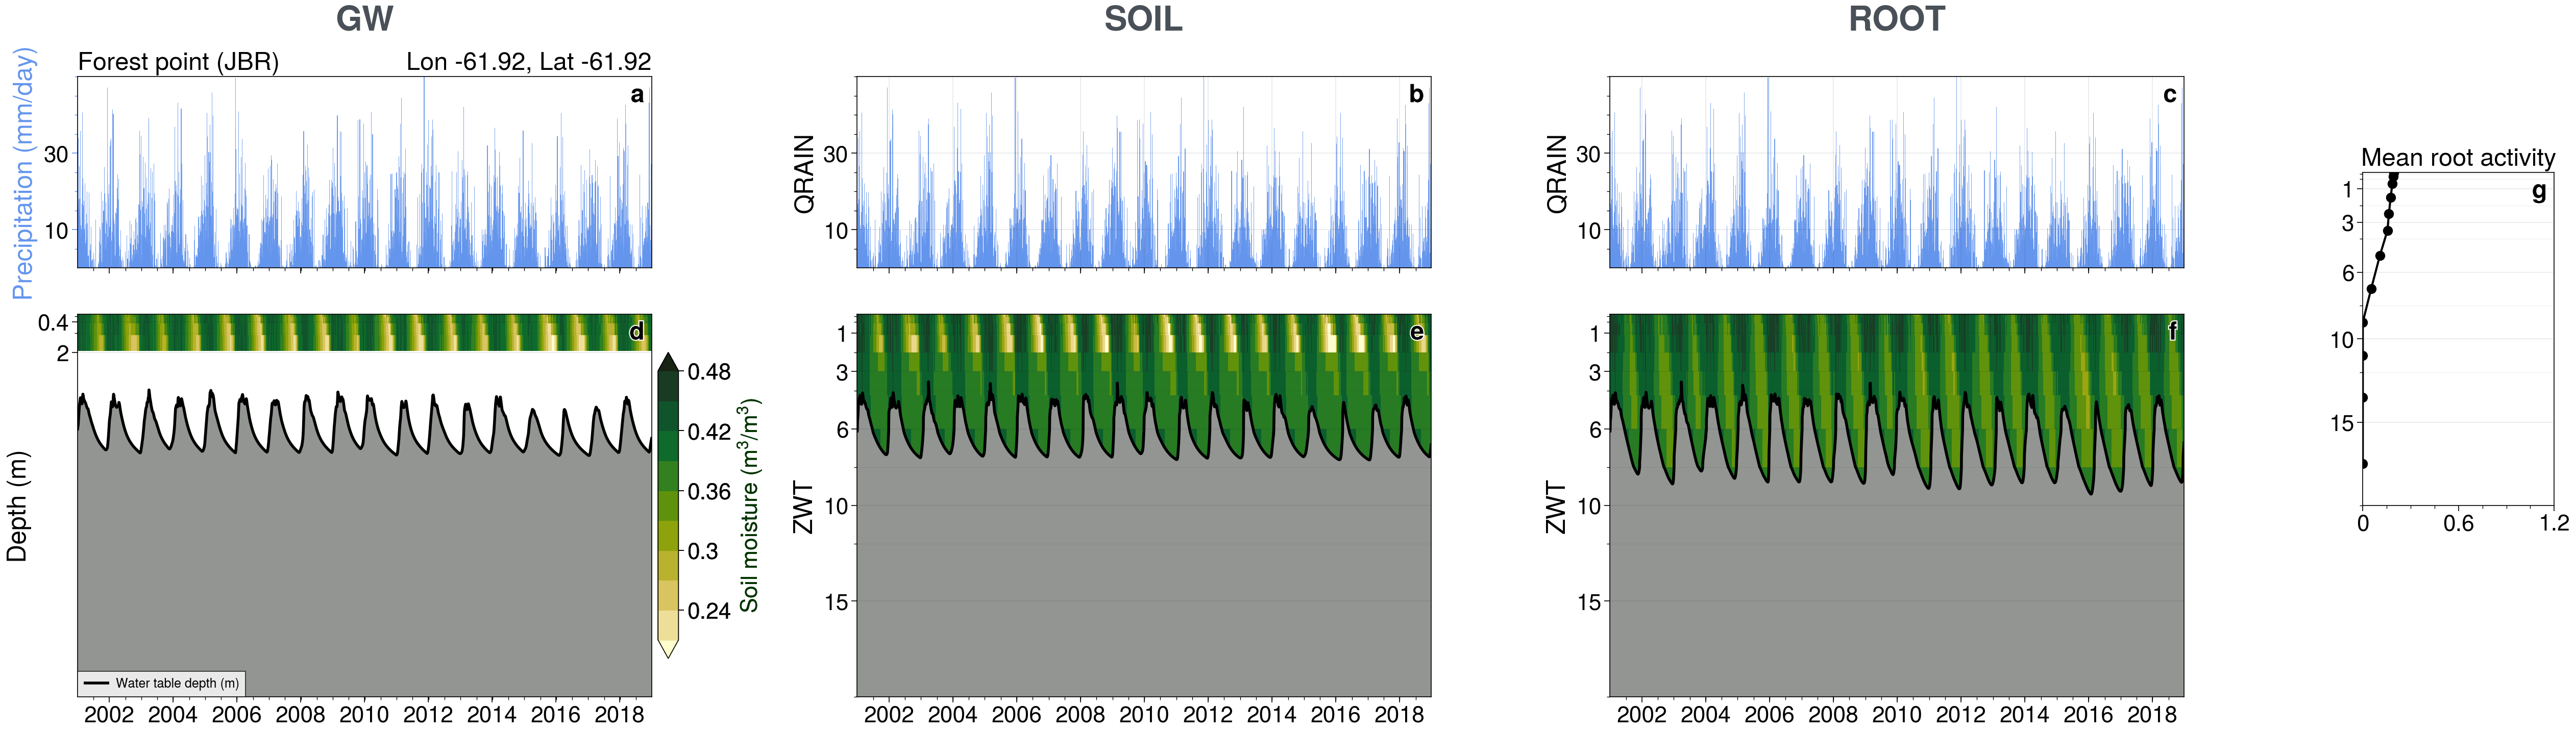

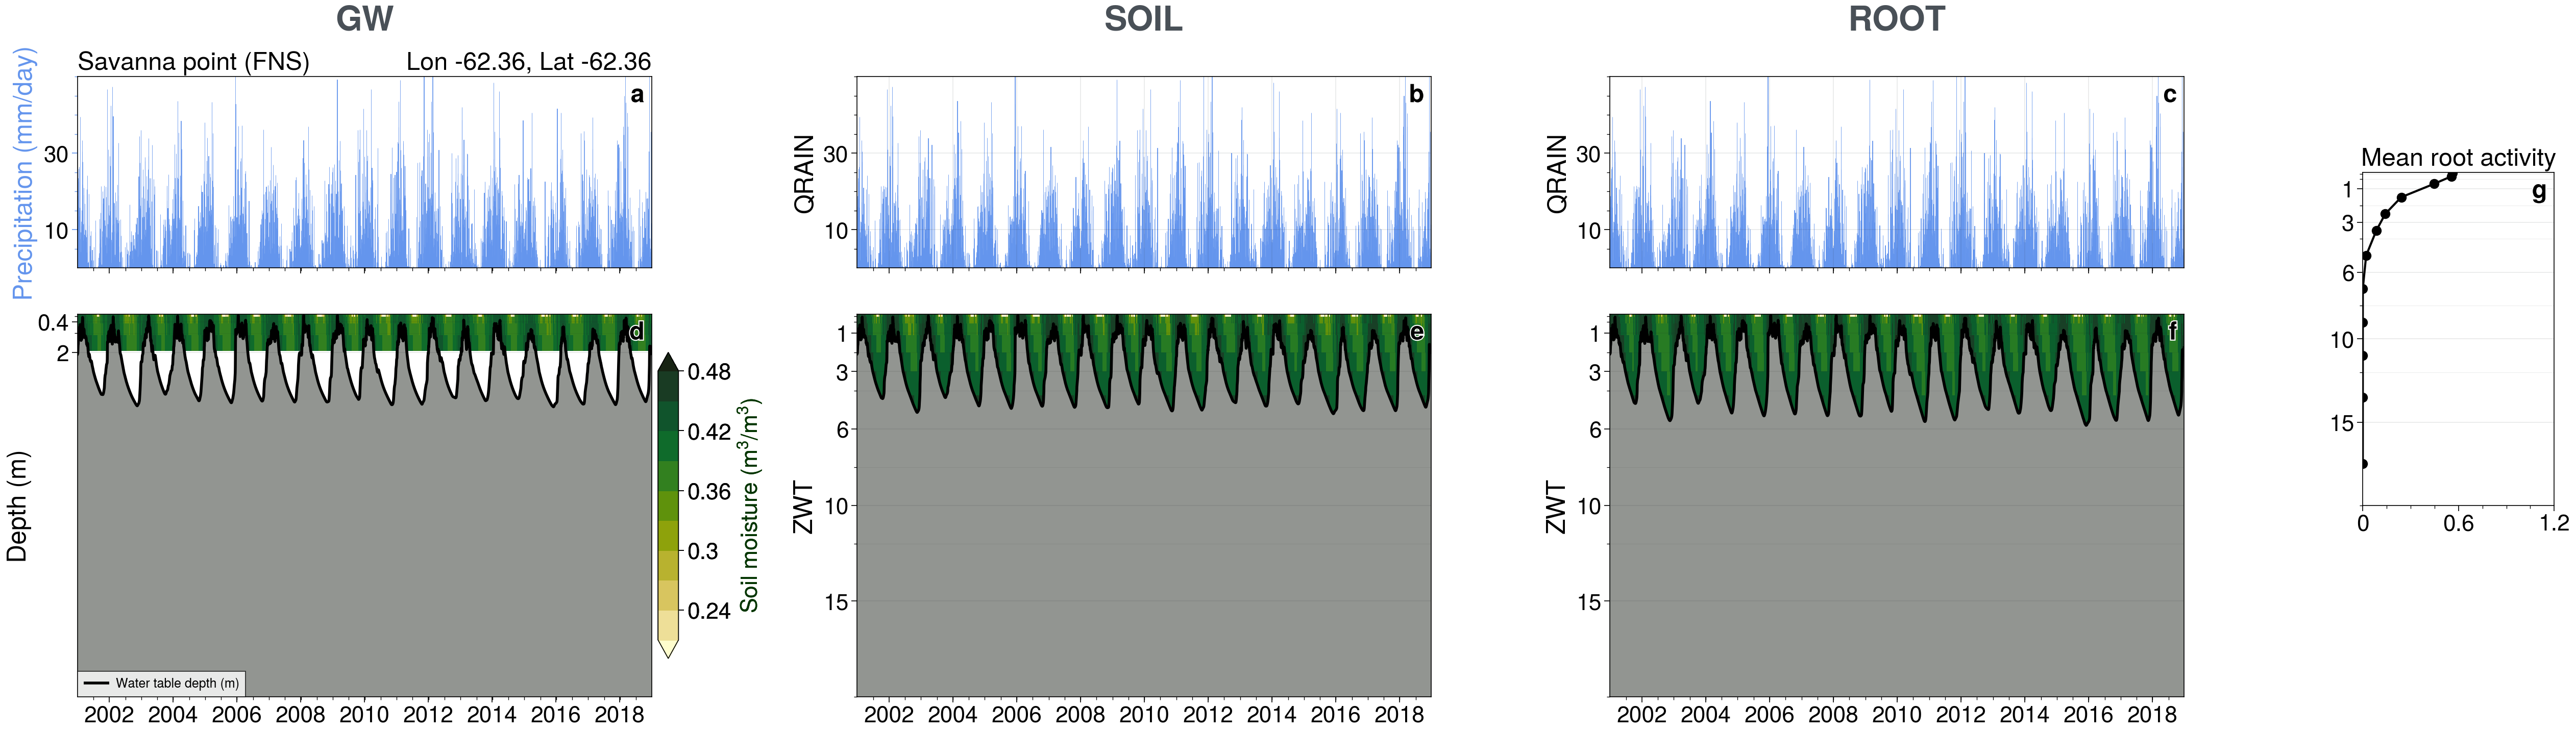

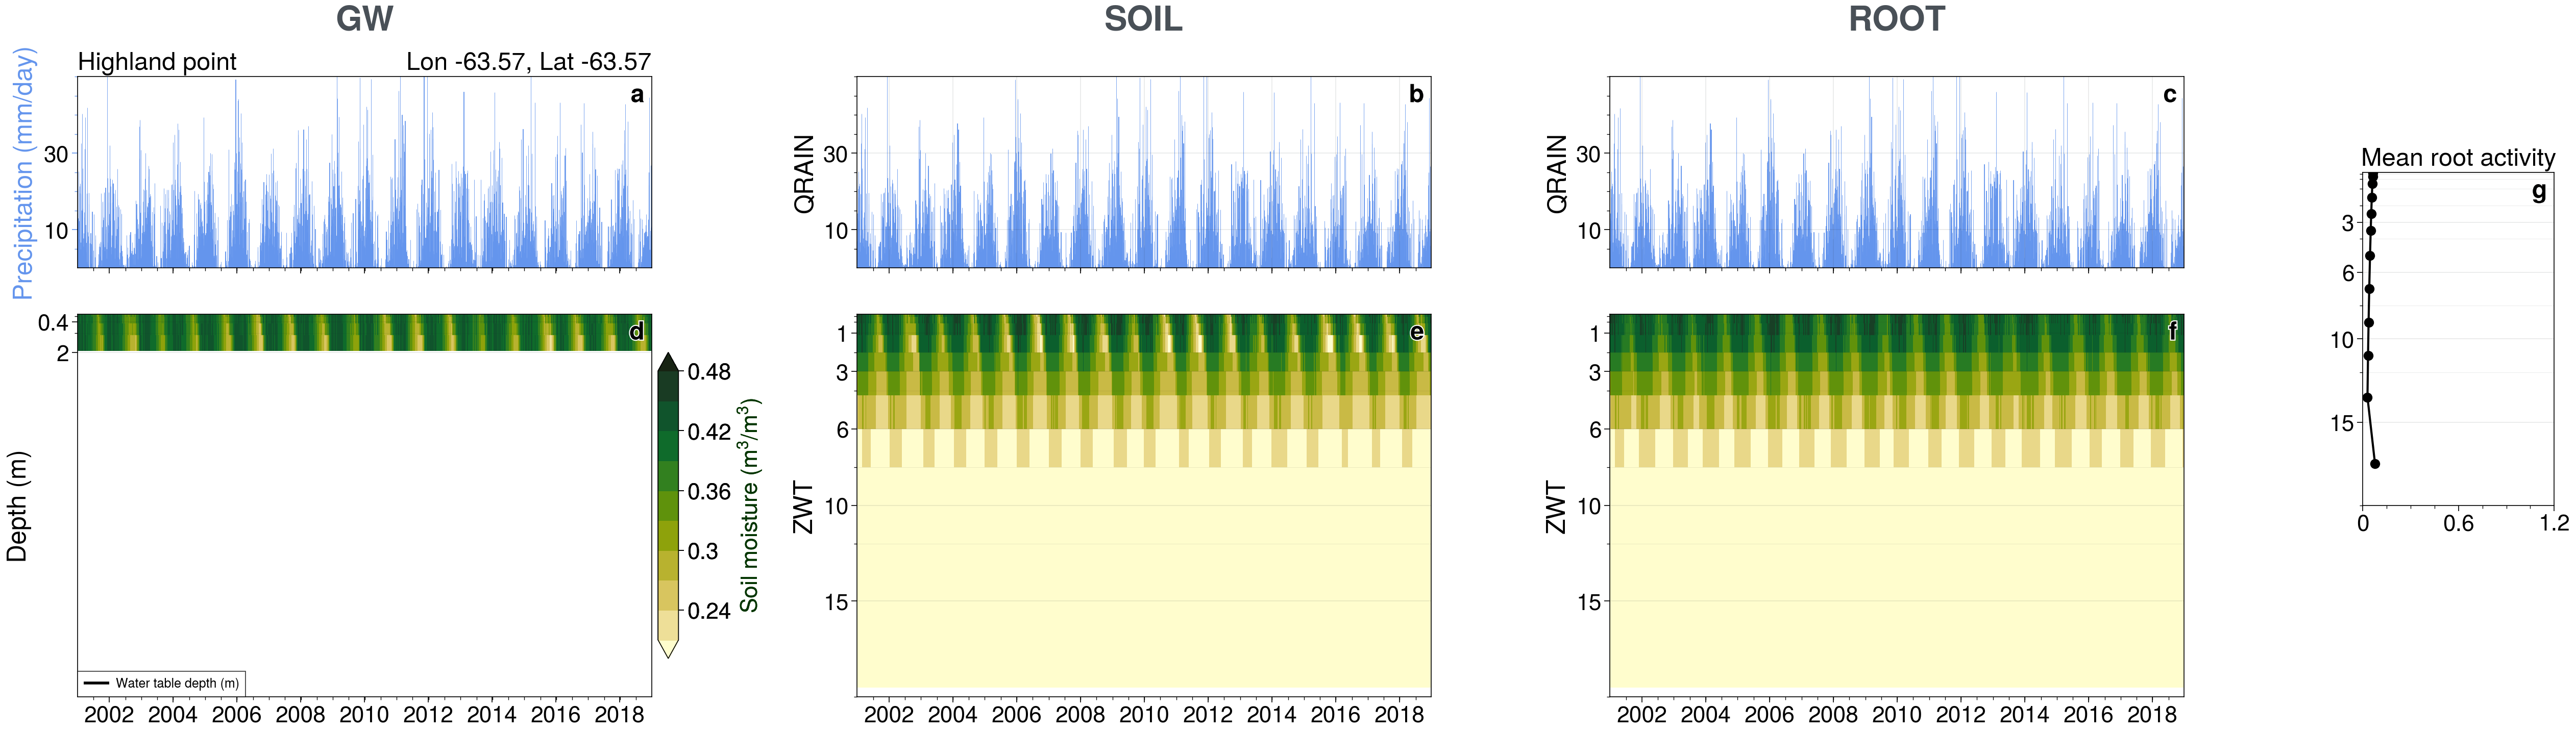

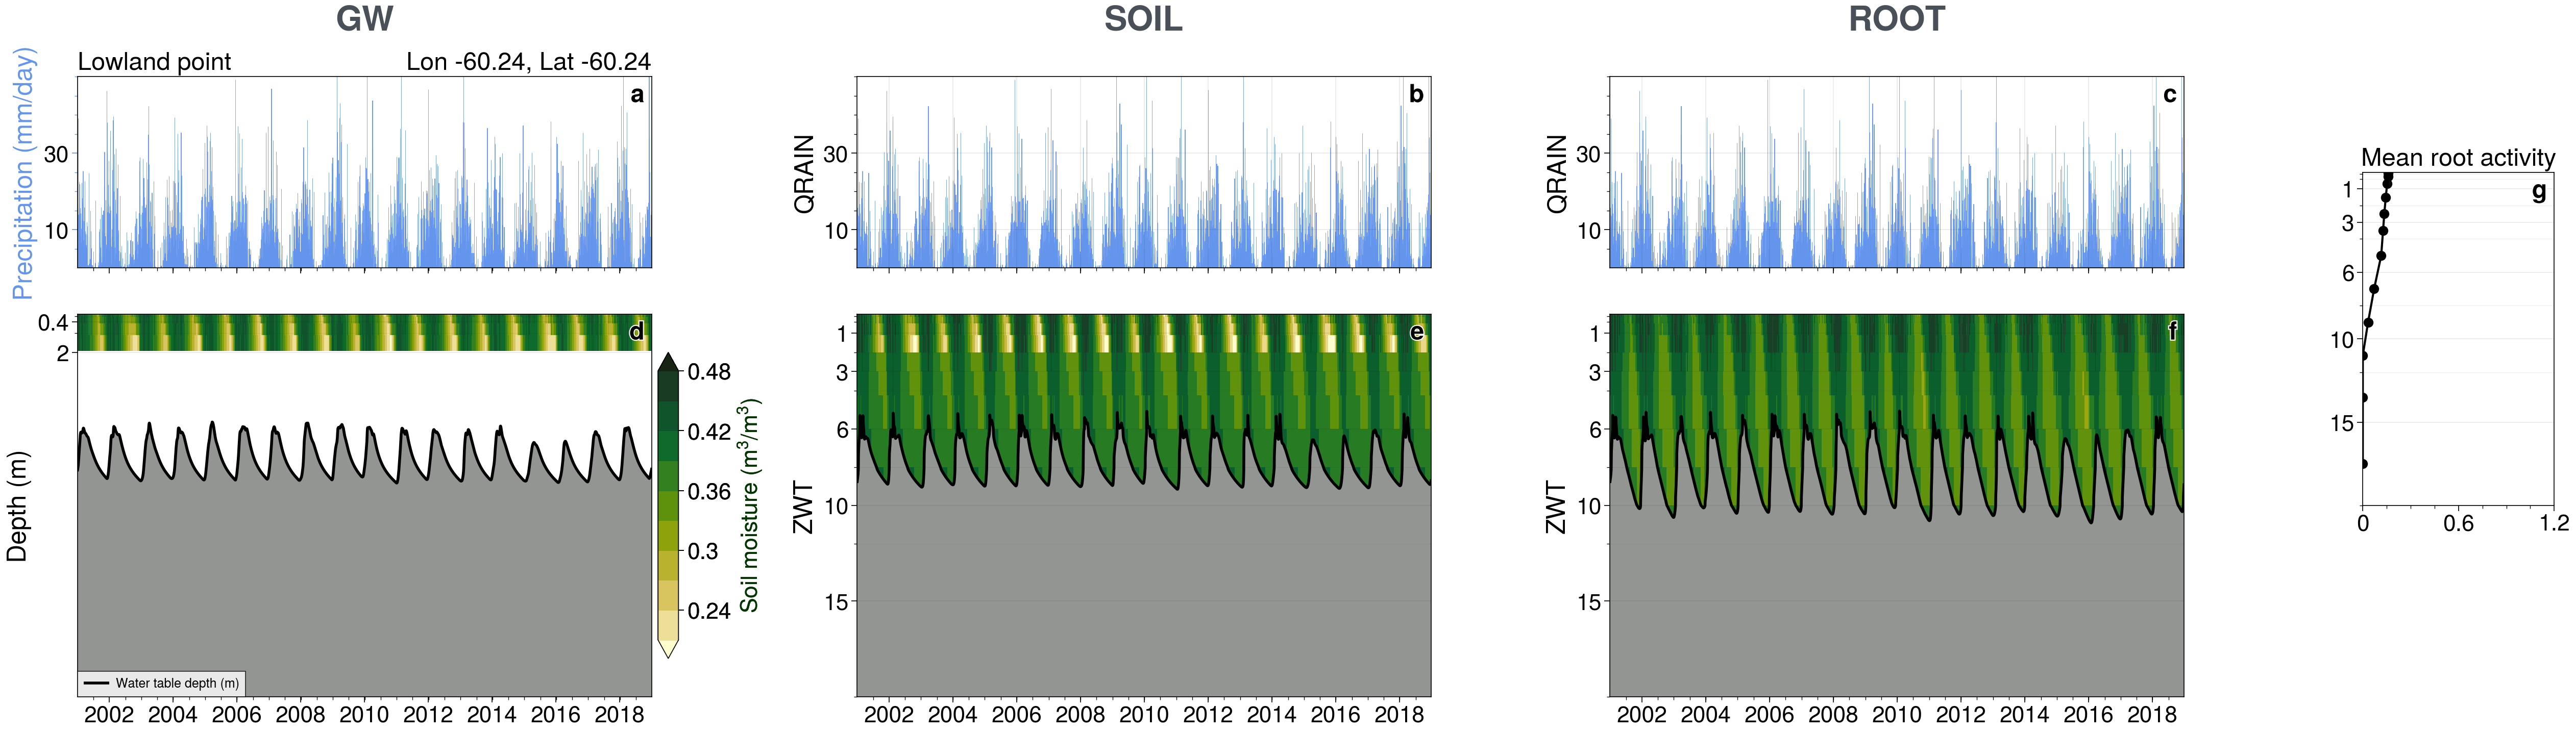

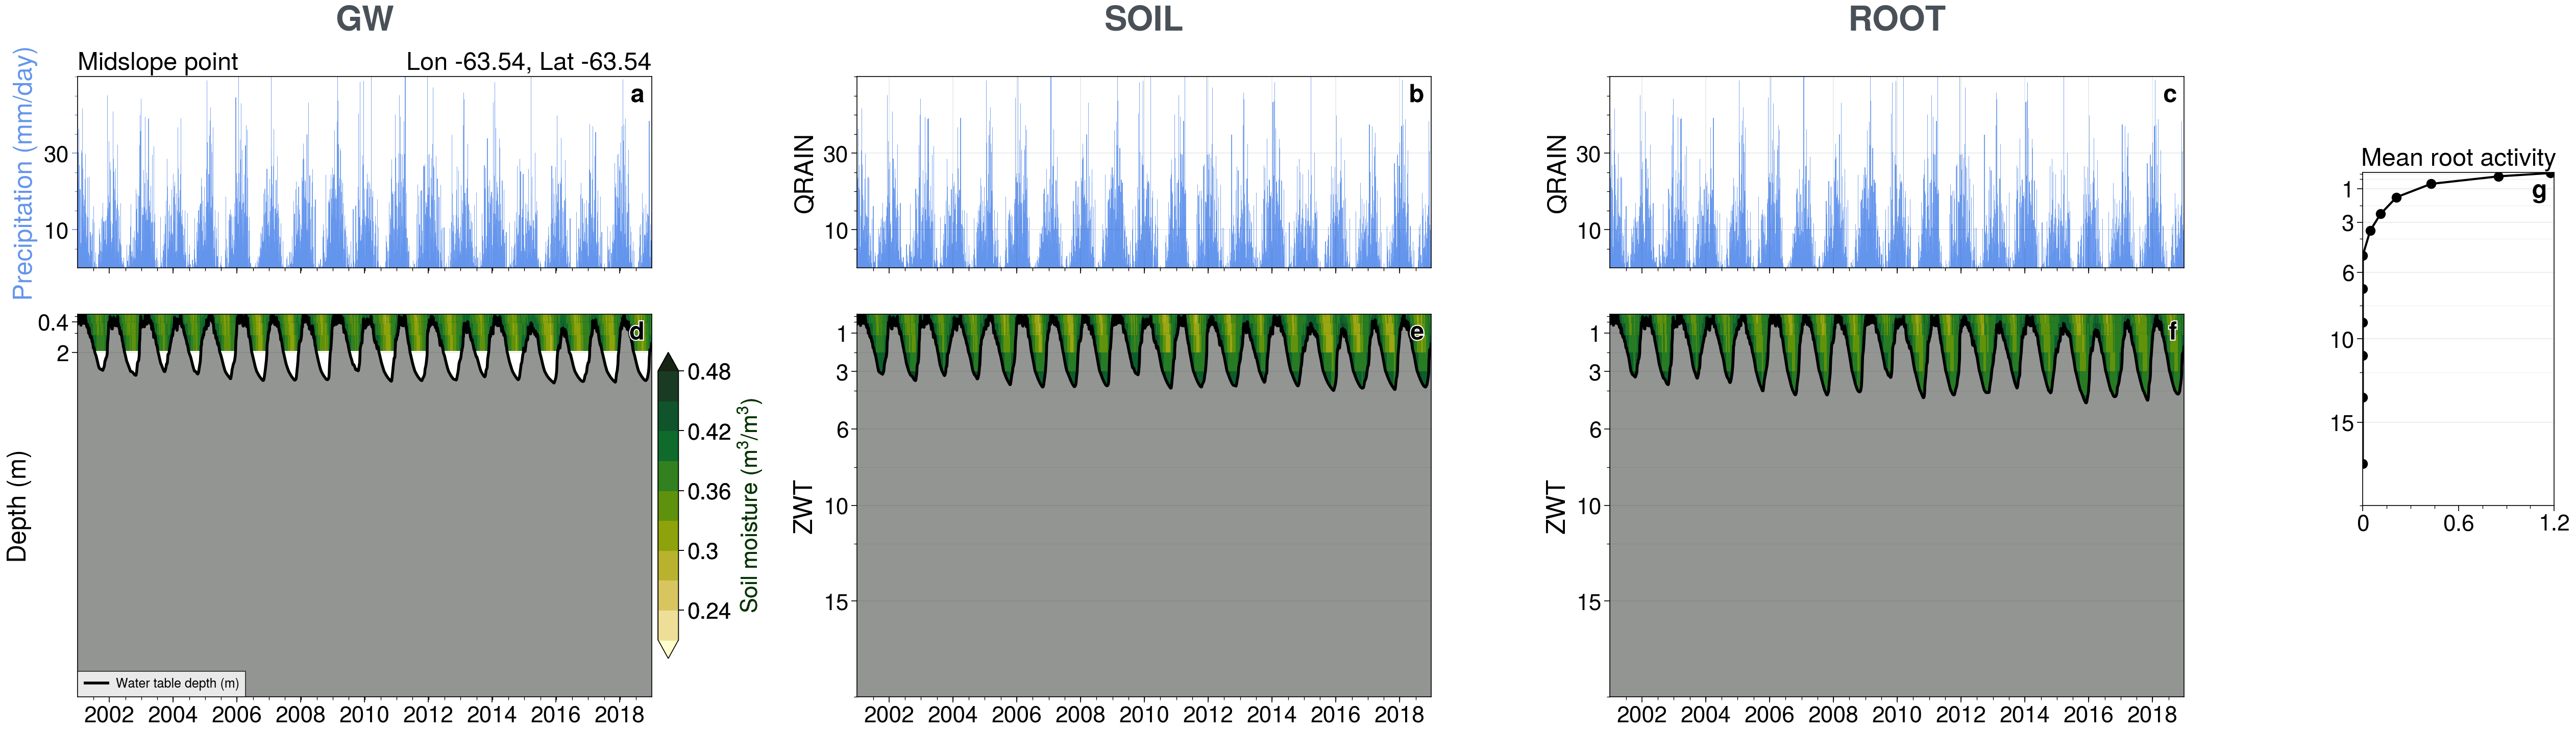

In [42]:
etpcpsm()

In [43]:
def uptake():
    
    i=0
    for pt in ['jbr', 'fns', 'high', 'mid', 'low']:

        depths = depths_roots
        if pt=='high':
            yticks = depths[::2][2:]
        else:
            yticks = depths[::2][1:]

        thick  = np.asarray([0.1]+[depths[x+1]-depths[x] for x in range(len(depths)-1)])

        fig  = pplt.figure(space=0, refwidth='45em', refheight='30em', sharey=False, sharex=False, 
                           wspace='8em')
        axs  = fig.subplots(nrows=1, ncols=1)

        uptake = data['roots'][pt]['UPTAKE']*86400
        time = pd.to_datetime(uptake['date'].values)

        cmap = pplt.Colormap(['goldenrod','white','vivid green','medium green'], listmode='continuous', cut=0.1)
        cmap.set_under('white')
        cmap.set_over('darkgreen')

        levels = MaxNLocator(nbins=8).tick_values(0.05,0.4)
        norm   = BoundaryNorm(levels, ncolors=cmap.N)

        cf = axs[0].pcolormesh(time, depths-(thick/2.), (uptake/thick).T,
                               cmap=cmap, norm=norm, shading='auto', extend='both')

        axs[0].plot(time, -1*data['roots'][pt]['ZWT'], color='black', linewidth=3, label='Water table depth (m)')
        axs[0].colorbar(cf, shrink=0.8, ticklabelsize=16, label='Uptake (mm/day per m)', labelsize=16)
        axs[0].set_xlabel('Time', fontsize=16)
        axs[0].set_ylabel('Depth (m)', fontsize=16)
        axs[0].legend(loc='ll', fontsize=12)
        axs[0].format(rtitle  = 'Lon ' + str(np.round(data['gw'][pt]['XLONG'].values,2)) + ', Lat ' + \
                                str(np.round(data['gw'][pt]['XLONG'].values,2)), ltitle = site_labels[i])

        axs.format(xrotation=0, yticklabelsize=16, xticklabelsize=16, titlesize=16, 
                   yreverse=True, ylocator=yticks, yminorlocator=depths, ygridminor=True, 
                   ygrid=True, xgrid=False)

        i+=1

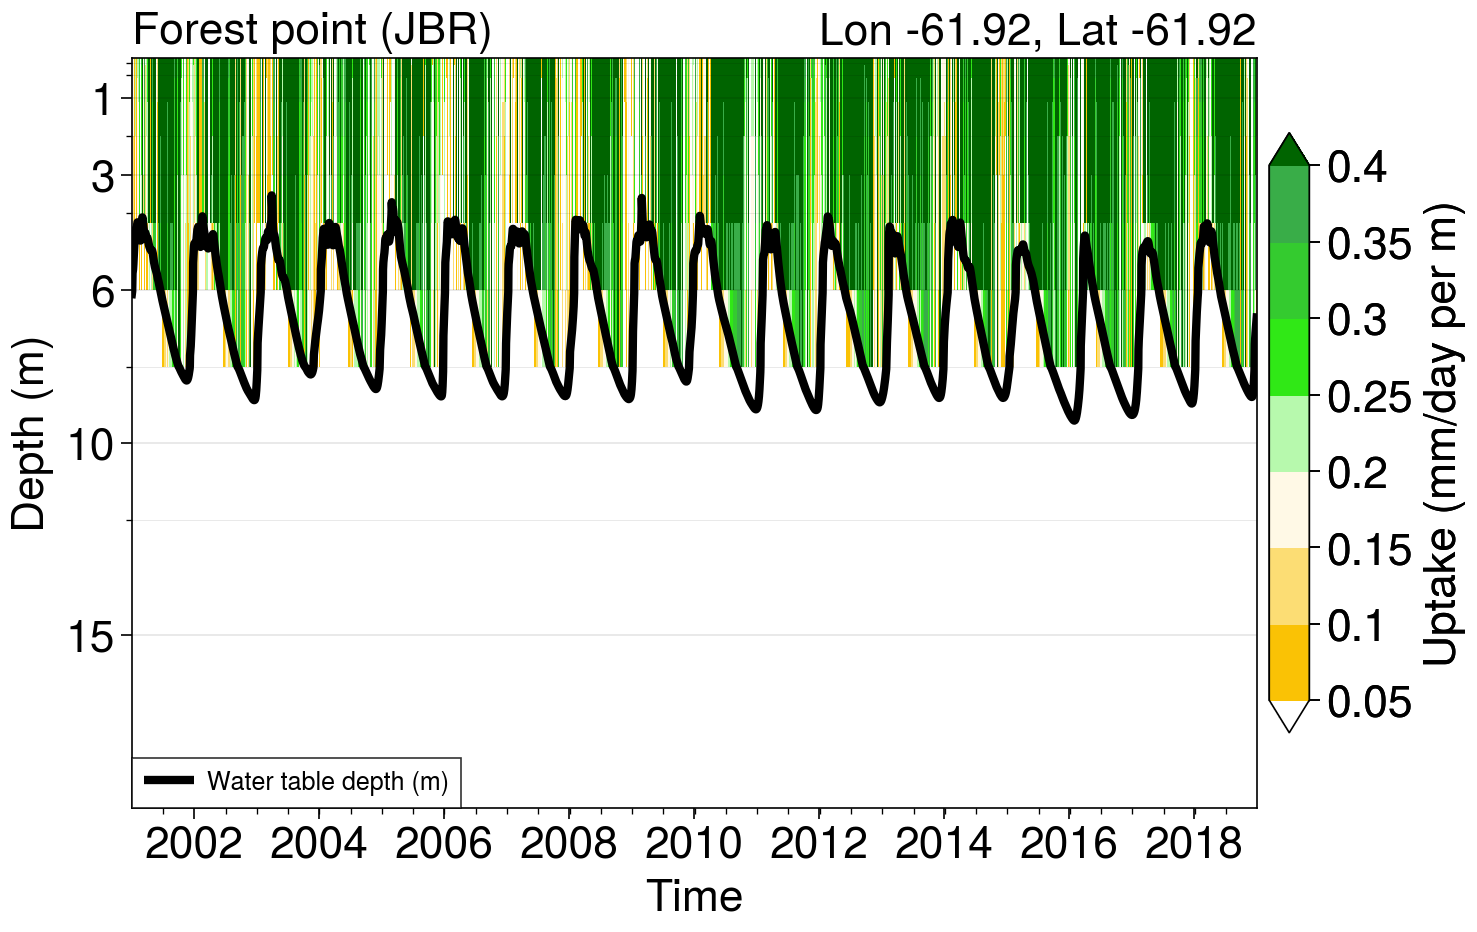

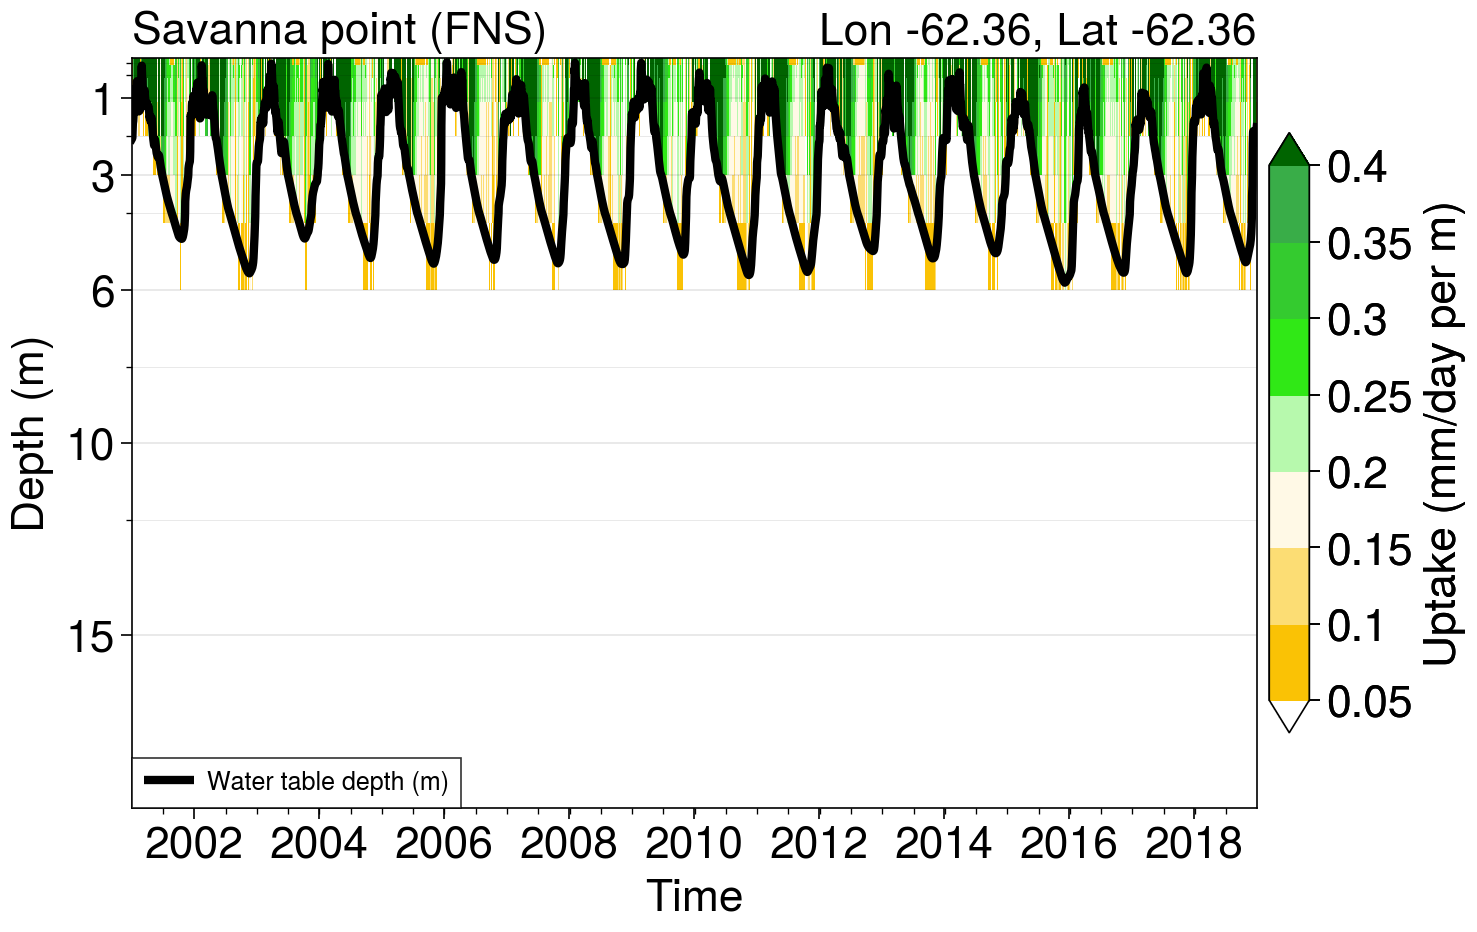

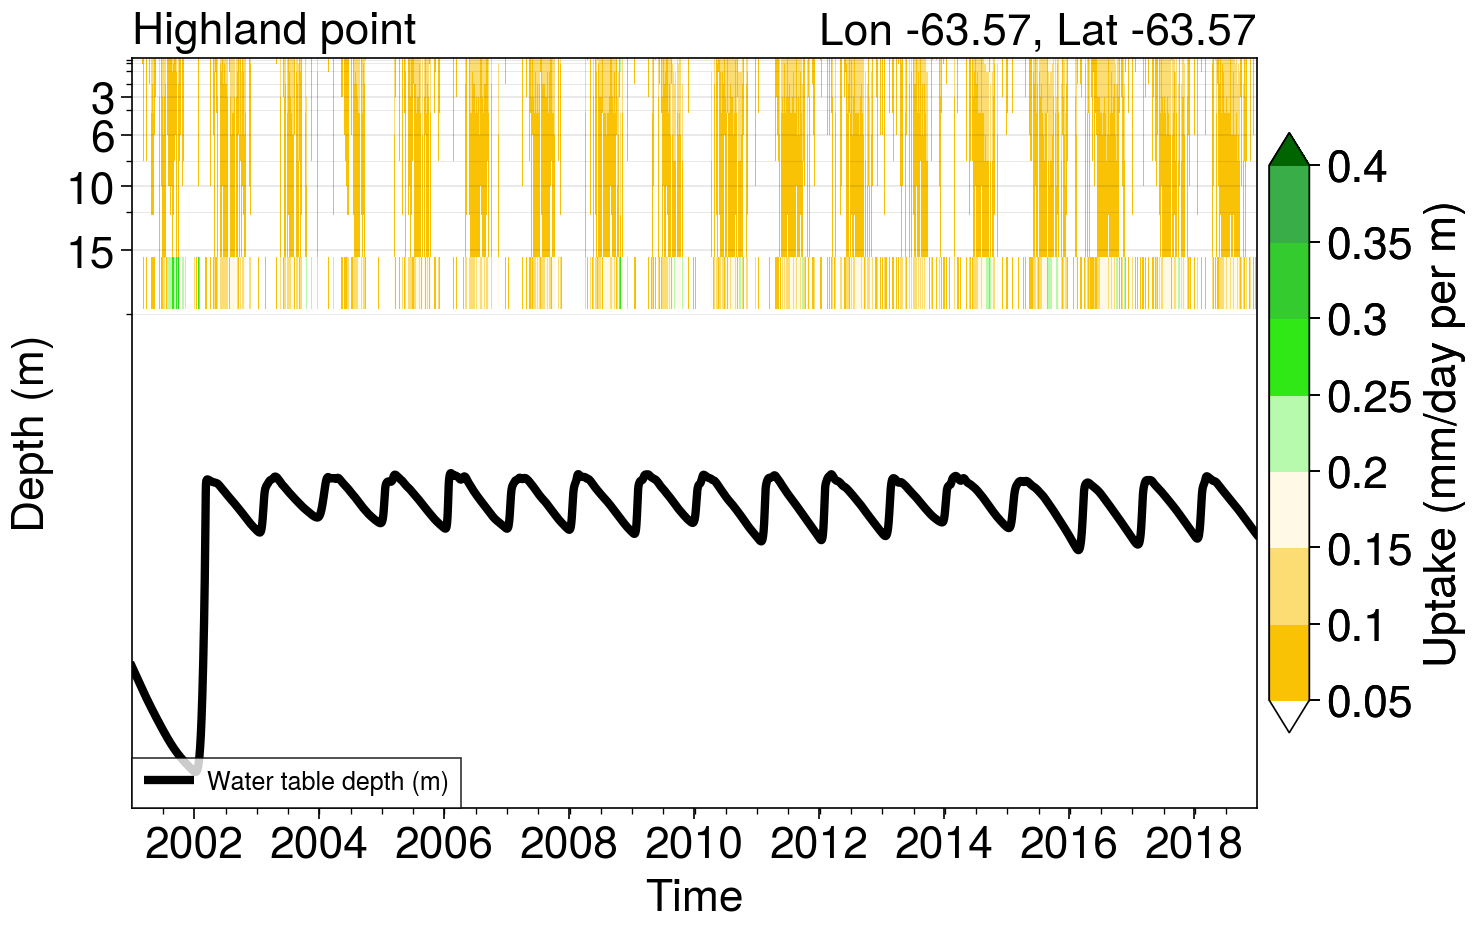

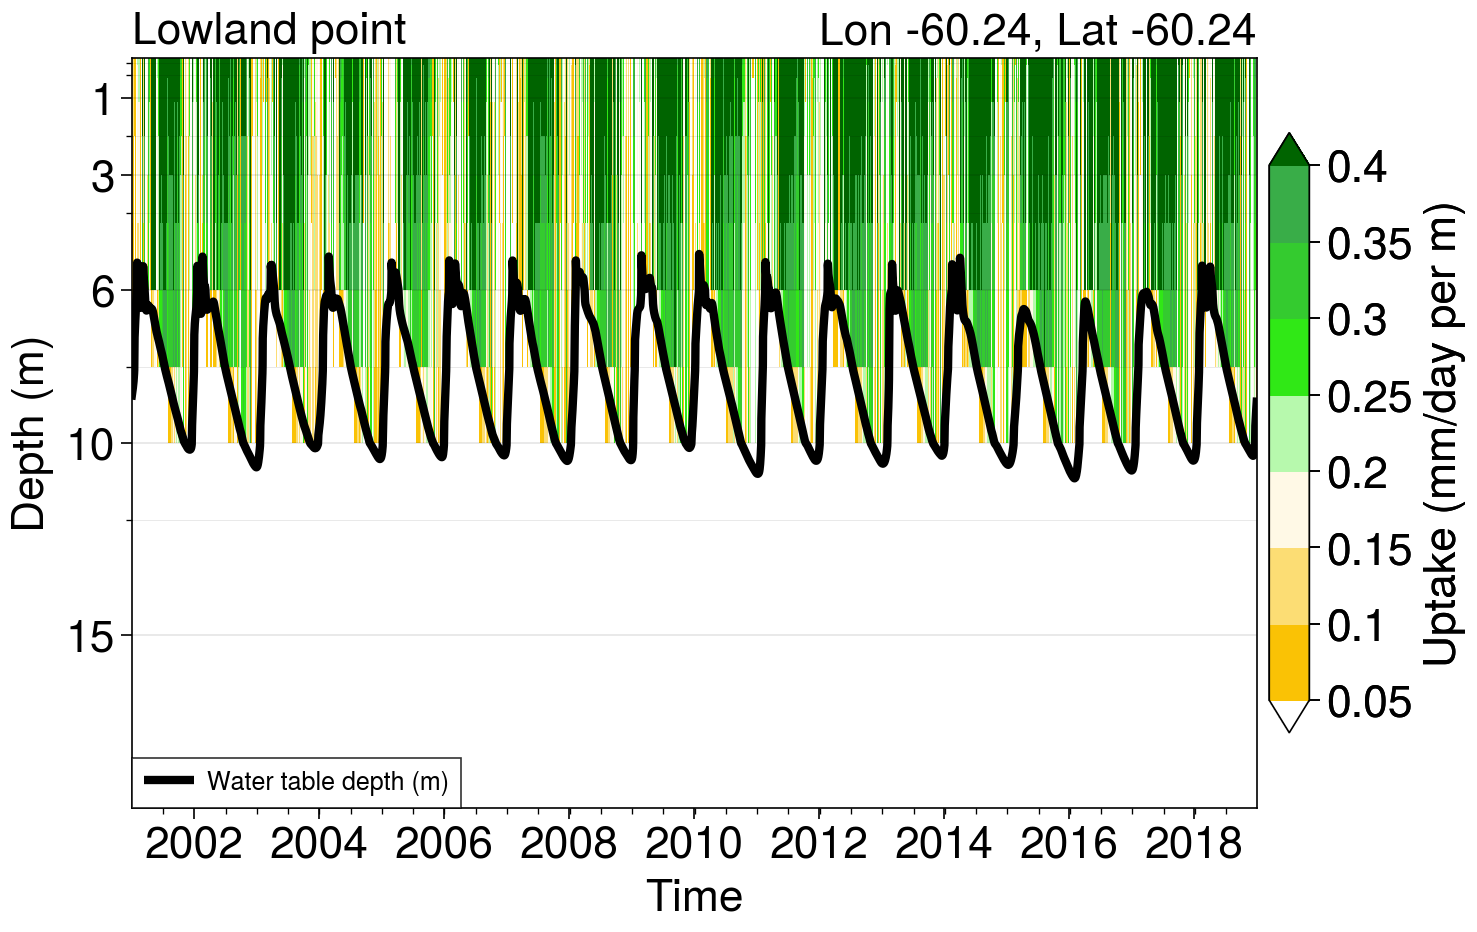

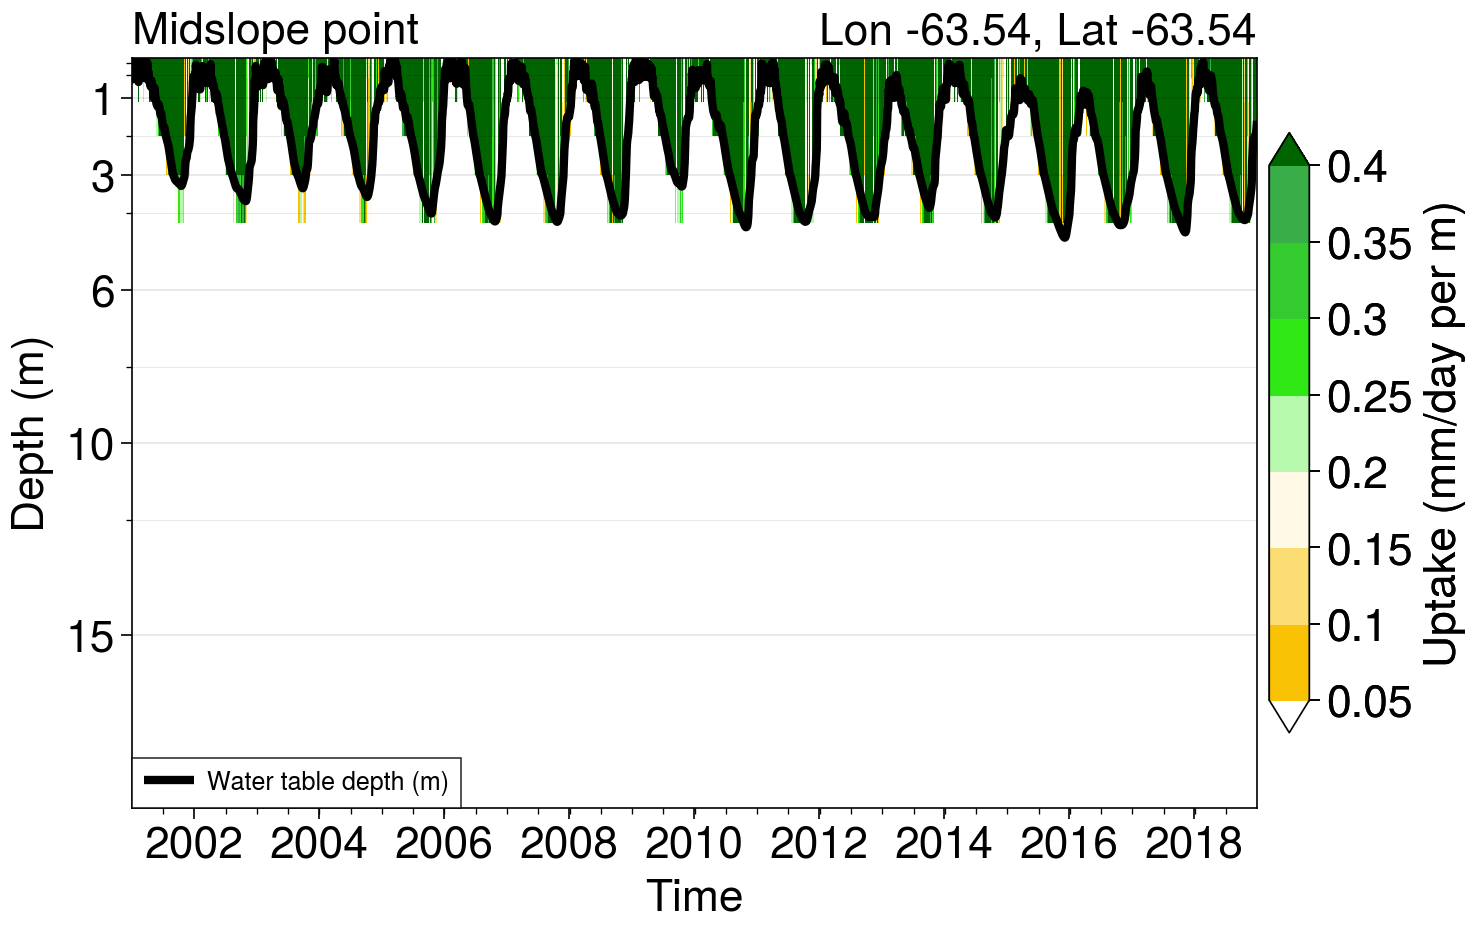

In [44]:
uptake()

## Annual plots

In [ ]:
def annual_fluxes():
    pplt.rc.cycle = 'FlatUI'
    i=0
    
    for pt in ['jbr', 'fns', 'high', 'mid', 'low']:

        fig = pplt.figure(refwidth='50em', refheight='15em', spanx=False)
        axs = fig.subplots(nrows=3, ncols=1, wspace=3, hspace=0)
        pax = axs[0].panel_axes('t', width='10en')

        for run in ['fd', 'gw', 'soil', 'roots']:

            doy  = data[run][pt][['ETRAN','LH','HFX','QRAIN']].groupby('date.dayofyear').mean()
            time = doy['dayofyear'].values

            if run=='fd':
                pax.bar(time, doy['QRAIN'].values*86400., color='royalblue', width=1, alpha=0.5)
                pax.format(uctitle='Precipitation (mm/day)', titlesize=14, xgrid=False, ygrid=False, ylim=(0,18),
                           ylocator=[0,18], yticklabelsize=14)

            axs[0].plot(time, doy['ETRAN'].values*86400.)
            axs[1].plot(time, doy['LH'].values, label=run)
            axs[2].plot(time, doy['HFX'].values)


        axs[0].format(ylocator=[0,2,4], ylim=(0,4), xlim=(0,365), ultitle='Transpiration (mm/day)', yformatter='sci', 
                      titlesize=14, ltitle=site_labels[i], rtitle= 'Lon ' + str(np.round(data['gw'][pt]['XLONG'].values,2)) + ', Lat ' + \
                                                                            str(np.round(data['gw'][pt]['XLONG'].values,2)))

        axs[1].legend(loc='ur', ncols=4, fontsize=12)
        axs[1].format(ylim=(0, 200), ylocator=[0,150], ultitle='Latent heat flux ($W/m^2$)', titlesize=14, xlabel='Day of year')

        axs[2].format(ylim=(-20, 150), ylocator=[0,100], ultitle='Sensible heat flux ($W/m^2$)', titlesize=14)

        fig.format(xlabelsize=14, xgrid=False, ygrid=False, yticklabelsize=14, xticklabelsize=14, abc='a',abcloc='ul', 
                  titlesize=14)

        i += 1

In [ ]:
annual_fluxes()

In [ ]:
def annual_et():
    
    i=0
    pplt.rc.cycle = 'FlatUI'
    
    for pt in ['jbr', 'fns', 'high', 'mid', 'low']:

        fig = pplt.figure(refwidth='50em', refheight='15em', spanx=False)
        axs = fig.subplots(nrows=3, ncols=1, wspace=3, hspace=0)

        for run in ['fd', 'gw', 'soil', 'roots']:

            doy  = data[run][pt][['ETRAN','ECAN','EDIR']].groupby('date.dayofyear').mean()
            time = doy['dayofyear'].values

            axs[0].plot(time, doy['ETRAN']*86400.)
            axs[1].plot(time, doy['ECAN']*86400, label=run)
            axs[2].plot(time, doy['EDIR']*86400)

            
        axs[0].format(ylocator=[0,2,4], ylim=(0,4), xlim=(0,365), ultitle='Transpiration (mm/day)', yformatter='sci', 
                      titlesize=14, ltitle=site_labels[i], rtitle='Lon ' + str(np.round(data['gw'][pt]['XLONG'].values,2)) + ', Lat ' + \
                                                                           str(np.round(data['gw'][pt]['XLONG'].values,2)))

        axs[1].legend(loc='ur', ncols=4, fontsize=12)
        axs[1].format(ylim=(-0.1,4), ylocator=[0,1,3], ultitle='Canopy evaporation (mm/day)', titlesize=14)

        axs[2].format(ylim=(-0.1,4), ylocator=[0,1,3], ultitle='Ground evaporation (mm/day)', titlesize=14, xlabel='Day of year')

        fig.format(xlabelsize=14, xgrid=False, ygrid=False, yticklabelsize=14, xticklabelsize=14, abc='a',abcloc='ul')

    i += 1

In [ ]:
annual_et()